<a href="https://colab.research.google.com/github/nutorbit/bandit/blob/main/notebooks/tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Multi-Armed Bandit

You might have heard of the Multi-Armed Bandit (MAB) problem. It is a subproblem of the reinforcement learning problem where we have a set of actions and we want to find the best action to take. The problem is that we don't know which action is the best. We can only try them and see which one gives us the best reward.

In this notebook, we will walk through the MAB problem and demonstrate how to solve it using MAB algorithms.

Mathematically, the MAB problem is defined as follows:

$$
\begin{align} 
\text{Given:} \quad & 
\mathcal{T} \text{ is a time horizon} \\ &
\mathcal{A} = \{a_1, a_2, \ldots, a_k\} \text{ is a set of actions, where } k \text{ is the number of actions} \\ &
\mathcal{R} \in \mathbb{R}, \mathcal{A} \to \mathcal{R} \text{ is a reward function} \\ &

\mathcal{a}_t \in \mathcal{A} \text{ is the action taken at time } t \text{, where } t \in \{1, 2, \ldots, \mathcal{T}\} \\ &
\mathcal{r}_t \in \mathcal{R} \text{ is the reward received at time } t \text{, where } t \in \{1, 2, \ldots, \mathcal{T}\} \\
\text{Find:} \quad & \mathcal{a}_t^* = \arg\max_{a \in \mathcal{A}} \mathbb{E}[\mathcal{R}(\mathcal{a})] \text{, where } \mathbb{E}[\cdot] \text{ is the expected value} \\ &
\mathcal{a}_t^* \text{ is the optimal action at time } t \text{, where } t \in \{1, 2, \ldots, \mathcal{T}\} \\ 
\text{Goal:} \quad & \mathbb{E}[\sum_{t=1}^{\mathcal{T}} \mathcal{r}_t] \text{ is maximized} \\
\end{align}
$$

The goal is to find the optimal action $\mathcal{a}_t^*$ at each time step $t$.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from abc import ABC, abstractmethod
from typing import List, Dict
from tqdm import trange

from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"

# Environment

In [ ]:
class SlotMachine:
    """
    A simple bernoulli slot machine simulation

    Args:
        reward_rates: the percentage of jackpot for each particular slot
        seed: random seed
    """

    def __init__(self, reward_rates: List = [0.2, 0.2, 0.3], seed: int = 123):
        self.reward_rates = reward_rates
        self.n_slots = len(reward_rates)
        self.rng = np.random.default_rng(seed)
        self.history = {}
        self.reset()

    @property
    def timesteps(self) -> int:
        return len(self.history["rewards"])

    def reset(self):
        self.history = {"rewards": [], "action": []}

    def get_performance_report(self) -> Dict:
        rewards = np.array(self.history["rewards"])
        action = np.array(self.history["action"])
        best_action = rewards.argmax(axis=1)

        indices = np.arange(self.timesteps).astype(int)

        reward_action = rewards[indices, action]
        best_reward_action = rewards[indices, best_action]

        return {
            "total_timesteps": self.timesteps,
            "total_reward": reward_action.sum(),
            "cummulative_reward": reward_action.cumsum(),
            "cummulative_regret": (best_reward_action - reward_action).cumsum()
        }

    def pull(self, slot_id: int) -> int:
        assert slot_id < self.n_slots, \
        f"slot_id should be less than {self.n_slots}"

        s = self.rng.uniform(size=self.n_slots)
        rewards = (s <= self.reward_rates).astype(int)
        self.history["rewards"].append(rewards)
        self.history["action"].append(slot_id)
        return rewards[slot_id]


Let's say we have a set of actions $\mathcal{A} = \{a_1, a_2, a_3\}$ imagine it is a slot machine. We have three slot machines and we want to find the best one to play. We don't know which one is the best, so we can only try them and see which one gives us the best reward with a time horizon of $\mathcal{T} = 10$.

Each action has a reward function $\mathcal{R}(\mathcal{a})$ which is bernoulli distribution with a probability of success $p(\mathcal{a})$. 

$$
\mathcal{R}(\mathcal{a}) = \begin{cases}
1 & \text{with probability } p(\mathcal{a}) \\
0 & \text{with probability } 1 - p(\mathcal{a})
\end{cases}
$$

Where $p(a_1) = 0.2$, $p(a_2) = 0.2$, and $p(a_3) = 0.3$.

We can define the environment as follows:

In [ ]:
env = SlotMachine(reward_rates=[0.2, 0.2, 0.3], seed=123)

Now, after we have defined the environment, we can try out pulling the slot machine and see what reward we get.

In [ ]:
env.pull(0)
env.pull(0)
env.pull(1)
env.pull(2)
env.pull(2)
env.pull(2)
env.pull(2)
env.pull(2)
env.pull(1)
env.pull(1)

0

1

0

1

0

1

1

0

1

0

So far, we have tried pulling the slot machine 10 times and we have received 5 rewards. Keep in that mind that we don't know which slot machine is the best, so we can only try them and see which one gives us the best reward.

# Agent

In [ ]:
class BaseAgent(ABC):
    """
    Base agent class
    """

    def __init__(self):
        self.history = {"reward": [], "action": []}

    @property
    def timesteps(self) -> int:
        return len(self.history["reward"])

    @abstractmethod
    def get_action(self) -> int:
        pass

    def save_feedback(self, action: int, reward: int):
        self.history["reward"].append(reward)
        self.history["action"].append(action)

In [ ]:
class NaiveAgent(BaseAgent):
    """
    An agent who only takes one specific action.

    Args:
        action: action
    """

    def __init__(self, action: int):
        super().__init__()
        self.action = action

    def get_action(self) -> int:
        return self.action


class RandomAgent(BaseAgent):
    """
    A random agent

    Args:
        n_actions: number of possible actions
        seed: random seed
    """

    def __init__(self, n_actions: int, seed: int = 123):
        super().__init__()
        self.n_actions = n_actions
        self.rng = np.random.default_rng(seed)

    def get_action(self) -> int:
        return self.rng.integers(0, self.n_actions)

# Helper functions

In [ ]:
def plot_regret(*args, **kwargs):
    """
    Plot cummulative regret from environment reports
    """

    fig, ax = plt.subplots(figsize=(10, 7))

    for i, report in enumerate(args):
        _ = ax.plot(
            report["cummulative_regret"], 
            label=i if "names" not in kwargs else kwargs["names"][i]
        )

    _ = ax.set_xlabel("timesteps")
    _ = ax.set_ylabel("cummulative regret")
    _ = plt.legend(loc="lower right")


def test_agent(
    agent: BaseAgent, 
    n: int,
    reward_rates: List[float] = [0.1, 0.2, 0.3], 
    seed: int = 123) -> Dict:
    """
    Test an agent in environment

    Args:
        agent: agent instance
        n: number of trials
        reward_rates: the percentage of jackpot for each particular slot
        seed: random seed

    Returns:
        result report
    """
    
    env = SlotMachine(reward_rates, seed=seed)

    for _ in trange(n):
        act = agent.get_action()
        rew = env.pull(act)
        agent.save_feedback(act, rew)

    return env.get_performance_report()

One of the most important things in MAB is to evaluate the performance of the agent. We can do this by calculating the cumulative reward and the cumulative regret. 

The cumulative reward is the sum of all the rewards we have received so far. The cumulative regret is the difference between the cumulative reward and the best possible cumulative reward.

$$
\begin{align}
\text{Cumulative reward:} \quad & \mathcal{R} = \sum_{t=1}^{\mathcal{T}} \mathcal{r}_t \\
\text{Cumulative regret:} \quad & \mathcal{R}^* = \sum_{t=1}^{\mathcal{T}} (\mathcal{r}_t^* - \mathcal{r}_t) \\
\text{where:} \quad & \mathcal{r}_t^* = \mathcal{R}(\mathcal{a}_t^*) \text{ is the best possible reward at time } t \text{, where } t \in \{1, 2, \ldots, \mathcal{T}\}
\end{align}
$$

We already implemented the helper functions for calculating the cumulative regret. Here is the example of how to use it:

In [ ]:
# first, get the report from environment
rep = env.get_performance_report()
rep

{'total_timesteps': 10,
 'total_reward': 5,
 'cummulative_reward': array([0, 1, 1, 2, 2, 3, 4, 4, 5, 5]),
 'cummulative_regret': array([1, 1, 1, 1, 1, 1, 1, 2, 2, 2])}

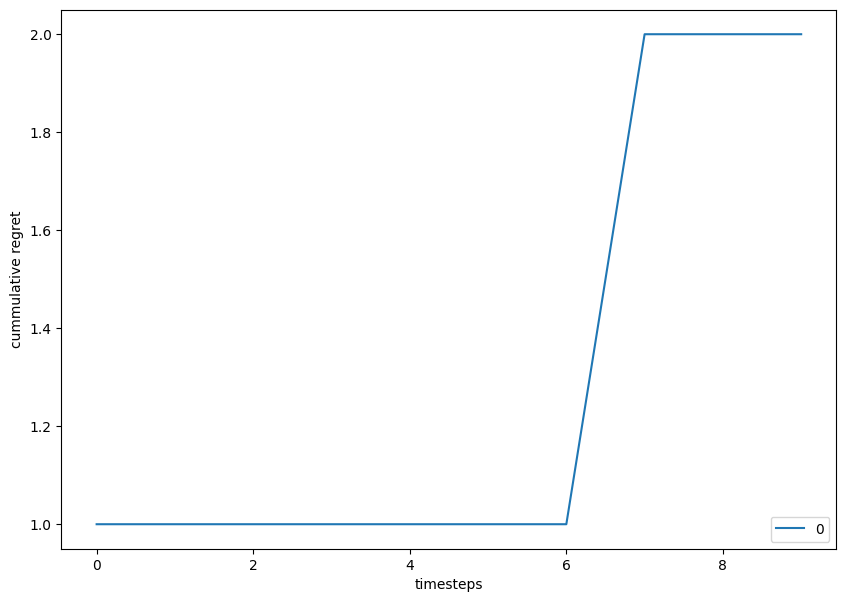

In [ ]:
# plot the cummulative regret
plot_regret(rep)

This is the cumulative regret for the first 10 time steps. You can interpret it as 10 times we have pulled the slot machine and we have missed the best reward 2 times.

Let's try `NaiveAgent` and see how it performs compared to the `RandomAgent`. `NaiveAgent` is an agent that always pulls one specific slot machine. We can define it as follows:

In [ ]:
agent = NaiveAgent(0)  # always take action 0
random_agent = RandomAgent(3)  # random agent

In [ ]:
# get the report from environment
rep = test_agent(
    agent=agent, 
    n=1_000, 
    reward_rates=[0.2, 0.2, 0.3],
    seed=123
)

# get the report from environment
rep_random = test_agent(
    agent=random_agent, 
    n=1_000, 
    reward_rates=[0.2, 0.2, 0.3],
    seed=123
)

100%|██████████| 1000/1000 [00:00<00:00, 99871.51it/s]


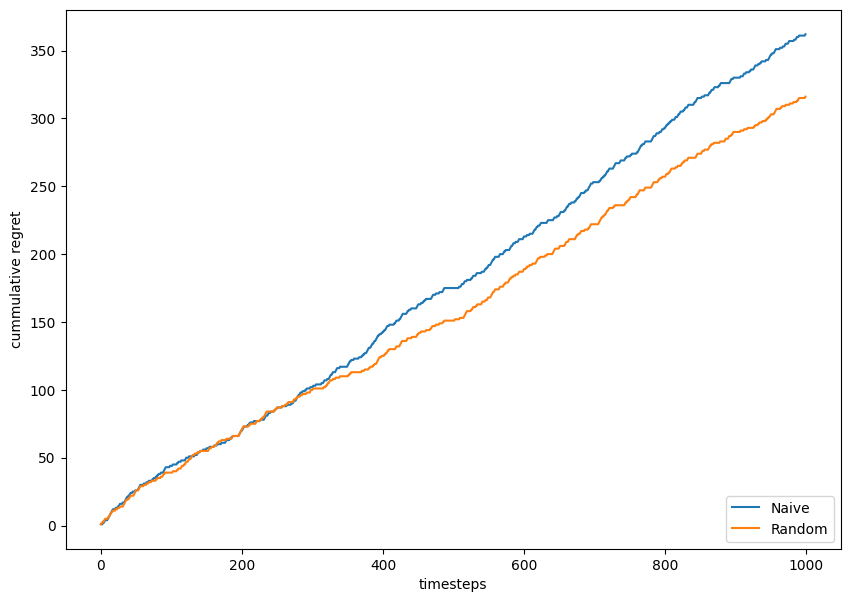

In [ ]:
plot_regret(rep, rep_random, names=["Naive", "Random"])

Looks like `NaiveAgent` is not doing very well compared to the `RandomAgent`.

Now, I encourage you to try out your own agent and see how it performs.

In [ ]:
# Define your custom agent here

# Experiment

In this section, we will run an experiment to compare the performance of different agents.

In [ ]:
REWARD_RATES = [0.2, 0.2, 0.3]
N_ACTIONS = len(REWARD_RATES)
TOTAL_TIMESTEPS = 1_000
SEED = 123

## Pulling only one specific action

Let's try pulling only one specific action with `NaiveAgent` and see how it performs.

In [ ]:
rep0 = test_agent(
    agent=NaiveAgent(0), 
    n=TOTAL_TIMESTEPS, 
    reward_rates=REWARD_RATES,
    seed=SEED
)

rep1 = test_agent(
    agent=NaiveAgent(1),
    n=TOTAL_TIMESTEPS, 
    reward_rates=REWARD_RATES,
    seed=SEED
)

rep2 = test_agent(
    agent=NaiveAgent(2),
    n=TOTAL_TIMESTEPS, 
    reward_rates=REWARD_RATES,
    seed=SEED
)

rep_random = test_agent(
    agent=RandomAgent(3),
    n=TOTAL_TIMESTEPS, 
    reward_rates=REWARD_RATES,
    seed=SEED
)

100%|██████████| 1000/1000 [00:00<00:00, 195493.08it/s]


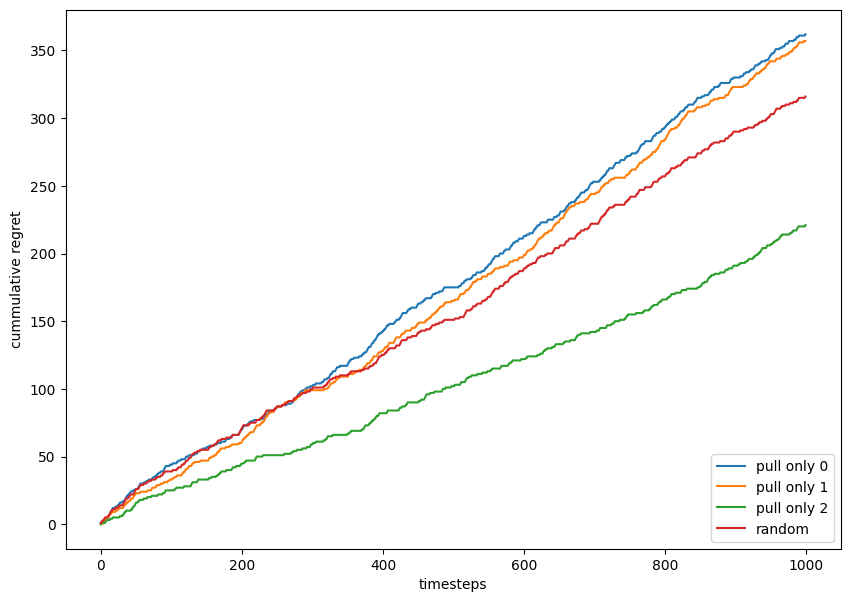

In [ ]:
plot_regret(rep0, rep1, rep2, rep_random, names=["pull only 0", "pull only 1", "pull only 2", "random"])

We experiment with three different actions: `0`, `1`, and `2`. We can see that `2` is the best action because it has the highest probability of success, of course!. 

## Epsilon-greedy

Let's try `EpsilonGreedyAgent` and see how it performs.

In [ ]:
class GreedyAgent(BaseAgent):
    """
    A greedy agent who takes only action with highest expected reward

    Args:
        n_actions: number of possible actions
    """

    def __init__(self, n_actions: int):
        super().__init__()
        self.n_actions = n_actions
        self.initilize_history()

    def initilize_history(self):
        for act in range(self.n_actions):
            self.history["reward"].append(1 + np.random.rand())
            self.history["action"].append(act)

    def calculate_expected_reward(self) -> pd.DataFrame:
        df = pd.DataFrame(self.history)
        expected_reward_action = df.groupby("action")["reward"].mean()
        return expected_reward_action.sort_values(ascending=False)

    def get_action(self) -> int:
        expected_reward_action = self.calculate_expected_reward()
        best_action = expected_reward_action.index[0]
        return best_action


class EpsilonGreedyAgent(GreedyAgent):
    """
    An epsilon greedy agent

    Args:
        n_actions: number of possible actions
        epsilon: epsilon hyperparameter
        seed: random seed
    """

    def __init__(self, n_actions: int, epsilon: float = 0.2, seed: int = 123):
        super().__init__(n_actions)
        self.epsilon = epsilon
        self.rng = np.random.default_rng(seed)

    def get_action(self) -> int:
        if self.rng.random() <= self.epsilon:
            action = self.rng.integers(0, self.n_actions)
        else:
            action = super().get_action()
        return action

In [ ]:
rep_es = test_agent(
    agent=EpsilonGreedyAgent(N_ACTIONS, epsilon=0.2),
    n=TOTAL_TIMESTEPS, 
    reward_rates=REWARD_RATES,
    seed=SEED
)

100%|██████████| 1000/1000 [00:01<00:00, 928.09it/s]


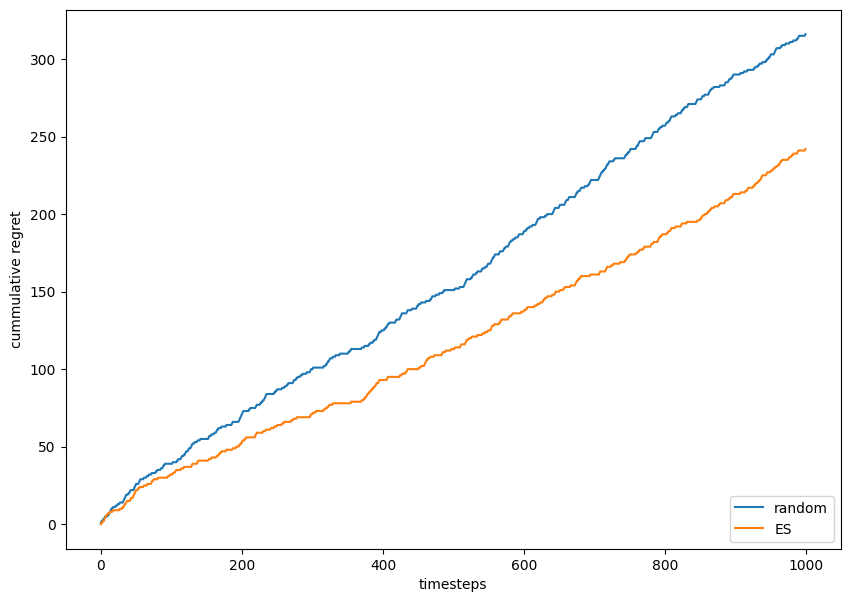

In [ ]:
plot_regret(rep_random, rep_es, names=["random", "ES"])

We set the value of $\epsilon$ to `0.2`. We can see that `EpsilonGreedyAgent` is doing better than `RandomAgent`.

## Explore-then-commit

Let's try `ExploreThenCommitAgent` and see how it performs.

In [ ]:
class ETCAgent(GreedyAgent):
    """
    A Explore-Then-Commit (ETC) agent

    Args:
        n_actions: number of possible actions
        n_explore: number of timesteps for exploration 
        seed: random seed
    """

    def __init__(self, n_actions: int, n_explore: int, seed: int = 123):
        super().__init__(n_actions)
        self.n_explore = n_explore
        self.rng = np.random.default_rng()

    def get_action(self) -> int:
        if self.timesteps <= self.n_explore:
            action = self.rng.integers(0, self.n_actions)
        else:
            action = super().get_action()
        return action

In [ ]:
rep_etc = test_agent(
    agent=ETCAgent(N_ACTIONS, n_explore=200),
    n=TOTAL_TIMESTEPS, 
    reward_rates=REWARD_RATES,
    seed=SEED
)

100%|██████████| 1000/1000 [00:01<00:00, 844.83it/s]


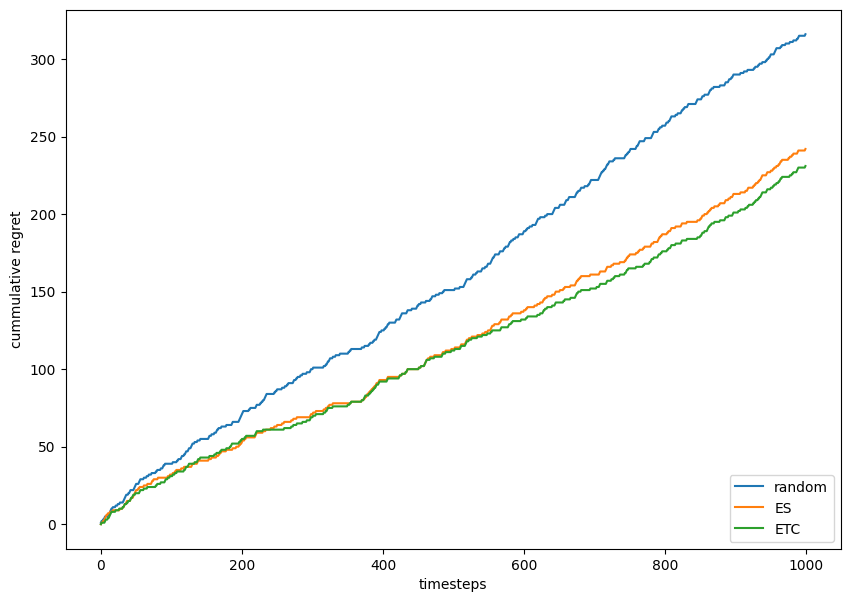

In [ ]:
plot_regret(rep_random, rep_es, rep_etc, names=["random", "ES", "ETC"])

The results are similar to `EpsilonGreedyAgent`.

## Upper Confidence Bound

Now, let's try `UpperConfidenceBoundAgent` and see how it performs.

In [ ]:
class UCBAgent(GreedyAgent):
    """
    An Upper Confidence Bound agent

    Args:
        n_actions: number of possible actions
        c: hyperparamer
    """

    def __init__(self, n_actions: int, c: float = 0.01):
        super().__init__(n_actions)
        self.c = c

    def calculate_expected_reward(self) -> pd.DataFrame:
        df = pd.DataFrame(self.history)
        expected_reward_action = df.groupby("action")["reward"].mean()
        n_action = df.groupby("action")["reward"].count()
        expected_reward_action += self.c * np.sqrt(np.log(self.timesteps) / n_action)
        return expected_reward_action.sort_values(ascending=False)

In [ ]:
rep_ucb = test_agent(
    agent=UCBAgent(N_ACTIONS),
    n=TOTAL_TIMESTEPS, 
    reward_rates=REWARD_RATES,
    seed=SEED
)

100%|██████████| 1000/1000 [00:01<00:00, 651.27it/s]


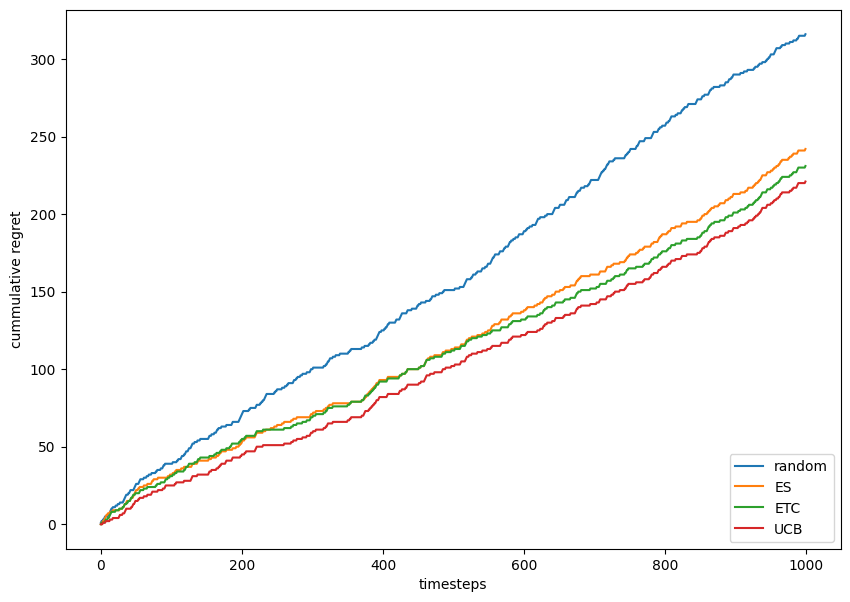

In [ ]:
plot_regret(rep_random, rep_es, rep_etc, rep_ucb, names=["random", "ES", "ETC", "UCB"])

We can see that `UpperConfidenceBoundAgent` is doing better than `EpsilonGreedyAgent`.

## Thompson sampling

Let's try `ThompsonSamplingAgent` and see how it performs.

In [ ]:
class TSAgent(GreedyAgent):
    """
    A Thompson Sampling agent with Beta distribution

    Args:
        n_actions: number of possible actions
        c: hyperparamer
    """

    def __init__(self, n_actions: int, c: float = 0.01, seed: int = 123):
        super().__init__(n_actions)
        self.c = c
        self.rng = np.random.default_rng(seed)

    def calculate_expected_reward(self) -> pd.DataFrame:
        df = pd.DataFrame(self.history)
        n_action = df.groupby("action")["reward"].count()
        n_success = df.groupby("action")["reward"].sum()
        n_failure = n_action - n_success
        expected_reward_action = self.rng.beta((n_success + 1) / self.c, (n_failure + 1) / self.c)
        return pd.Series(expected_reward_action, index=n_action.index).sort_values(ascending=False)

In [ ]:
rep_ts = test_agent(
    agent=TSAgent(N_ACTIONS),
    n=TOTAL_TIMESTEPS, 
    reward_rates=REWARD_RATES,
    seed=SEED
)

100%|██████████| 1000/1000 [00:01<00:00, 643.56it/s]


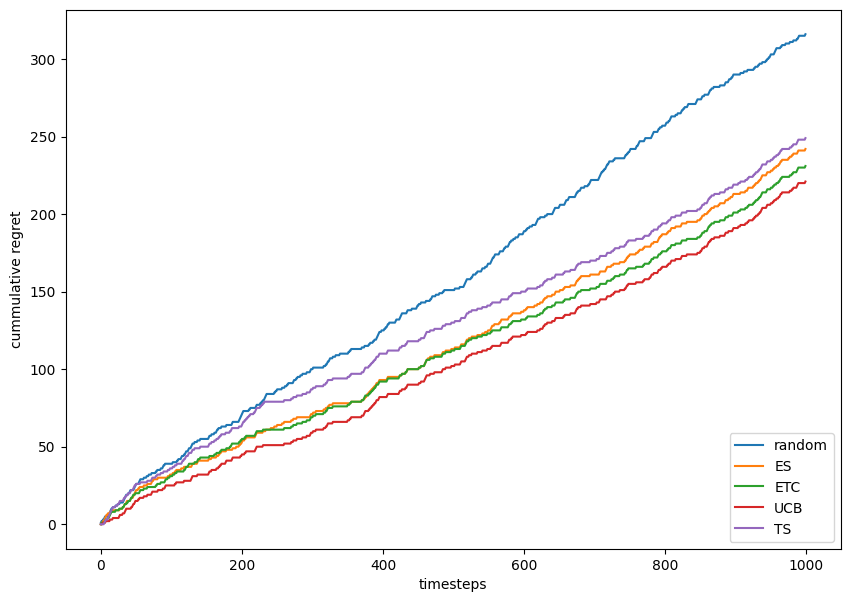

In [ ]:
plot_regret(rep_random, rep_es, rep_etc, rep_ucb, rep_ts, names=["random", "ES", "ETC", "UCB", "TS"])

We can see that `ThompsonSamplingAgent` is doing better than `UpperConfidenceBoundAgent`.

# Conclusion

In this notebook, we have learned how to solve the MAB problem using MAB algorithms. We have implemented different MAB algorithms and compared their performance. We can see that `ThompsonSamplingAgent` is doing the best. However, it is important to note that the performance of the agent depends on the environment. For example, if the reward function is not bernoulli distribution, then the performance of the agent will be different.

In the next notebook, we will learn more about `Contextual Bandit` which is an extension of MAB.

# References

* [Multi-Armed Bandit Problem](https://en.wikipedia.org/wiki/Multi-armed_bandit)
* [Bandit Algorithms](https://tor-lattimore.com/downloads/book/book.pdf)